In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
!pip install ipython-sql

In [3]:
%load_ext sql

In [4]:
%sql sqlite://

In [13]:
import pandas as pd

df = pd.read_csv("/kaggle/input/ecommerce-data/data.csv",
                encoding="latin1",
                parse_dates=["InvoiceDate"])

In [15]:
# df.head()

In [16]:
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)
df.to_sql("orders", con=engine, index=False, if_exists="replace")

541909

In [19]:
from sqlalchemy import text

def q(sql: str) -> pd.DataFrame:
    return pd.read_sql_query(sql, con=engine)

q("PRAGMA table_info(orders);")

q("""
SELECT 
  COUNT(*) AS rows,
  MIN(InvoiceDate) AS min_date,
  MAX(InvoiceDate) AS max_date
FROM orders;
""")

,rows,min_date,max_date
0,541909,2010-12-01 08:26:00.000000,2011-12-09 12:50:00.000000


### Create Clean View (`orders_net`)
Fixing the data preprocessing standard in one place ensures that all subsequent queries operate with a consistent data definition.

In [22]:
with engine.begin() as conn:
    conn.execute(text("DROP VIEW IF EXISTS orders_net;"))
    conn.execute(text("""
    CREATE VIEW orders_net AS
    SELECT *
    FROM orders
    WHERE InvoiceNo NOT LIKE 'C%'
        AND Quantity > 0
        AND UnitPrice > 0
        AND CustomerId IS NOT NULL;
    """))

### Monthly Metrics View (`v_monthly_metrics`)
Monthly aggregation is a fundamental axis of a dashboard, so fixing it as a view makes it easy to reuse.

In [27]:
with engine.begin() as conn:
    conn.execute(text("DROP VIEW IF EXISTS v_monthly_metrics;"))
    conn.execute(text("""
    CREATE VIEW v_monthly_metrics AS
    SELECT
        strftime("%Y-%m", InvoiceDate) AS ym,
        ROUND(SUM(Quantity * UnitPrice), 2) AS Revenue,
        COUNT(DISTINCT InvoiceNo) AS Orders,
        COUNT(DISTINCT CustomerID) AS Customers
    FROM orders_net
    GROUP BY ym
    ORDER BY ym;
    """))

In [30]:
q("SELECT * FROM v_monthly_metrics LIMIT 10;")

,ym,Revenue,Orders,Customers
0,2010-12,572713.89,1400,885
1,2011-01,569445.04,987,741
2,2011-02,447137.35,997,758
3,2011-03,595500.76,1321,974
4,2011-04,469200.36,1149,856
5,2011-05,678594.56,1555,1056
6,2011-06,661213.69,1393,991
7,2011-07,600091.01,1331,949
8,2011-08,645343.90,1280,935
9,2011-09,952838.38,1755,1266


### Top-N Analysis (Customers / Products)

In [33]:
# Top 10 Customers by revenue
q("""
SELECT
    CustomerID,
    ROUND(SUM(Quantity * UnitPrice), 2) AS revenue
FROM orders_net
GROUP BY CustomerID
ORDER BY revenue DESC
LIMIT 10;
""")

,CustomerID,revenue
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06
5,12415.0,124914.53
6,14156.0,117379.63
7,17511.0,91062.38
8,16029.0,81024.84
9,12346.0,77183.60


In [34]:
# Top 10 Products by revenue
q("""
SELECT
    StockCode,
    MAX(Description) AS Name,
    ROUND(SUM(Quantity * UnitPrice), 2) AS Revenue
FROM orders_net
GROUP BY StockCode
ORDER BY Revenue DESC
LIMIT 10;
""")

,StockCode,Name,Revenue
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,22423,REGENCY CAKESTAND 3 TIER,142592.95
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,100603.50
3,85099B,JUMBO BAG RED RETROSPOT,85220.78
4,23166,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POST,POSTAGE,77803.96
6,47566,PARTY BUNTING,68844.33
7,84879,ASSORTED COLOUR BIRD ORNAMENT,56580.34
8,M,Manual,53779.93
9,23084,RABBIT NIGHT LIGHT,51346.20


### New vs Returning Revenue View (`v_new_vs_return`)
By showing the revenue trends divided into **"first-time customers vs. returning customers for that month"** we can immediately explain retention insights.

In [36]:
with engine.begin() as conn:
    conn.execute(text("DROP VIEW IF EXISTS v_new_vs_return;"))
    conn.execute(text("""
        CREATE VIEW v_new_vs_return AS
        WITH first_purchase AS (
            SELECT
                CustomerID,
                MIN(strftime("%Y-%m", InvoiceDate)) AS first_ym
            FROM orders_net
            GROUP BY CustomerID
        ),
        monthly AS (
            SELECT
                strftime("%Y-%m", InvoiceDate) AS ym,
                CustomerID,
                SUM(Quantity * UnitPrice) AS Revenue
            FROM orders_net
            GROUP BY ym, CustomerID
        )
        SELECT
            m.ym,
            ROUND(SUM(CASE WHEN fp.first_ym = m.ym THEN m.Revenue ELSE 0 END), 2) AS new_rev,
            ROUND(SUM(CASE WHEN fp.first_ym < m.ym THEN m.Revenue ELSE 0 END), 2) AS return_rev
        FROM monthly m
        JOIN first_purchase fp USING (CustomerID)
        GROUP BY m.ym
        ORDER BY m.ym;
    """))

In [37]:
q("SELECT * FROM v_new_vs_return;")

,ym,new_rev,return_rev
0,2010-12,572713.89,0.00
1,2011-01,293207.35,276237.69
2,2011-02,158142.07,288995.28
3,2011-03,200069.96,395430.80
4,2011-04,122011.49,347188.87
5,2011-05,124103.78,554490.78
6,2011-06,135742.95,525470.74
7,2011-07,74008.75,526082.26
8,2011-08,79756.10,565587.80
9,2011-09,155103.90,797734.48


### Country-wise Revenue (Top Countries)
Key countries when **geographical insights** are needed.

In [38]:
q("""
SELECT
    Country,
    ROUND(SUM(Quantity * UnitPrice), 2) AS Revenue
FROM orders_net
GROUP BY Country
ORDER BY Revenue DESC
LIMIT 10;
""")

,Country,Revenue
0,United Kingdom,7308391.55
1,Netherlands,285446.34
2,EIRE,265545.90
3,Germany,228867.14
4,France,209024.05
5,Australia,138521.31
6,Spain,61577.11
7,Switzerland,56443.95
8,Belgium,41196.34
9,Sweden,38378.33


### Export Results (CSV)  &  Visualization (3 Key Charts)

In [39]:
monthly = q("SELECT * FROM v_monthly_metrics;")

top_customers = q("""
SELECT
    CustomerID, ROUND(SUM(Quantity*UnitPrice), 2) AS Revenue
FROM orders_net GROUP BY CustomerID ORDER BY Revenue DESC LIMIT 10;
""")

top_products = q("""
SELECT
    StockCode, MAX(Description) AS Name, ROUND(SUM(Quantity*UnitPrice), 2) AS Revenue
FROM orders_net GROUP BY StockCode ORDER BY Revenue DESC LIMIT 10;
""")

new_return = q("SELECT * FROM v_new_vs_return;")

monthly.to_csv("/kaggle/working/monthly_metrics.csv", index=False)
top_customers.to_csv("/kaggle/working/top_customers.csv", index=False)
top_products.to_csv("/kaggle/working/top_products.csv", index=False)
new_return.to_csv("/kaggle/working/new_vs_return.csv", index=False)

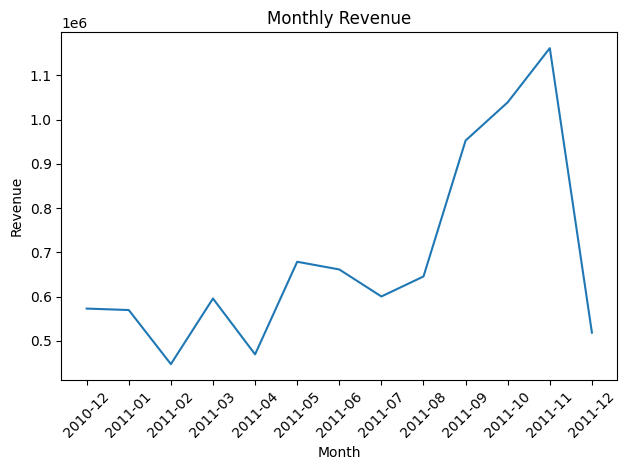

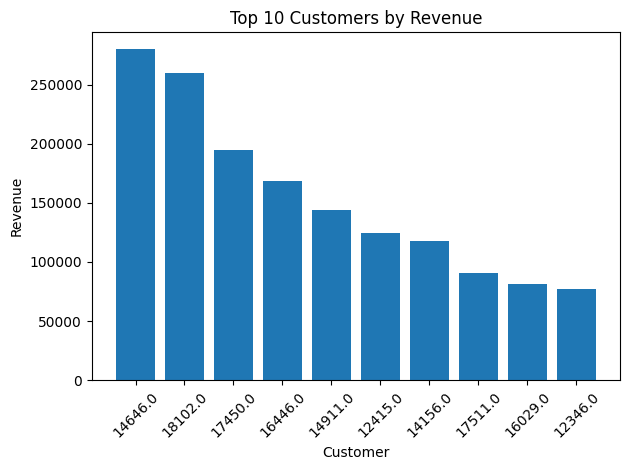

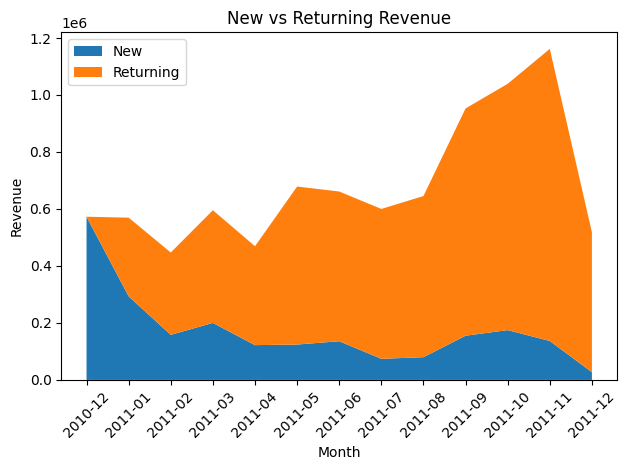

In [48]:
import matplotlib.pyplot as plt

# MONTHLY REVENUE
plt.figure()
plt.plot(monthly['ym'], monthly['Revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.savefig('/kaggle/working/fig_monthly_revenue.png')

# TOP 10 CUSTOMERS
plt.figure()
plt.bar(top_customers['CustomerID'].astype(str), top_customers['Revenue'])
plt.xticks(rotation=45)
plt.title('Top 10 Customers by Revenue')
plt.xlabel('Customer')
plt.ylabel('Revenue')
plt.tight_layout()
plt.savefig('/kaggle/working/fig_top_customers.png')

# NEW VS. RETURNING REVENUE
plt.figure()
plt.stackplot(new_return['ym'], new_return['new_rev'], new_return['return_rev'], labels=['New','Returning'])
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title('New vs Returning Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.savefig('/kaggle/working/fig_new_vs_return.png')